# import

In [1]:
%load_ext autoreload
%autoreload 2

In [10]:
import os
os.environ["MKL_NUM_THREADS"] = "2"
os.environ["NUMEXPR_NU M_THREADS"] = "2"
os.environ["OMP_NUM_THREADS"] = "2"
import numpy as np
import tqdm
import time
import random

import torch
import torch.nn as nn
import torch.utils.data as data
import torch.nn.functional as F
from torch.optim.lr_scheduler import LambdaLR
from advertorch.attacks import GradientSignAttack
from torch.utils.tensorboard import SummaryWriter

In [19]:
import sys
sys.path.append("../src/")

from datasetManager import DatasetManager
from generators import Dataset
import signal_augmentations as sa 
from models import cnn

# Utils

## Metrics

In [12]:
class Metrics:
    def __init__(self, epsilon=1e-10):
        self.value = 0
        self.accumulate_value = 0
        self.count = 0
        self.epsilon = epsilon
        
    def reset(self):
        self.accumulate_value = 0
        self.count = 0
        
    def __call__(self):
        self.count += 1

        
class BinaryAccuracy(Metrics):
    def __init__(self, epsilon=1e-10):
        Metrics.__init__(self, epsilon)
        
    def __call__(self, y_pred, y_true):
        super().__call__()
        
        with torch.set_grad_enabled(False):
            y_pred = (y_pred>0.5).float()
            correct = (y_pred == y_true).float().sum()
            self.value = correct/ (y_true.shape[0] * y_true.shape[1])
            
            self.accumulate_value += self.value
            return self.accumulate_value / self.count
        
        
class CategoricalAccuracy(Metrics):
    def __init__(self, epsilon=1e-10):
        Metrics.__init__(self, epsilon)
        
    def __call__(self, y_pred, y_true):
        super().__call__()
        
        with torch.set_grad_enabled(False):
            self.value = torch.mean((y_true == y_pred).float())
            self.accumulate_value += self.value

            return self.accumulate_value / self.count

        
class Ratio(Metrics):
    def __init__(self, epsilon=1e-10):
        Metrics.__init__(self, epsilon)
        
    def __call__(self, y_pred, y_adv_pred):
        super().__call__()
        
        results = zip(y_pred, y_adv_pred)
        results_bool = [int(r[0] != r[1]) for r in results]
        self.value = sum(results_bool) / len(results_bool) * 100
        self.accumulate_value += self.value
        
        return self.accumulate_value / self.count

In [13]:
import datetime
def get_datetime():
    now = datetime.datetime.now()
    return str(now)[:10] + "_" + str(now)[11:-7]

# Initialization

## set seeds

In [14]:
def reset_seed(seed):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark = False
reset_seed(1324)

In [88]:
class crnn(nn.Module):
    def __init__(self):
        super(crnn, self).__init__()
        
        self.features = nn.Sequential(
            ConvBNReLU(1, 64, 3, 1, 1),
            nn.MaxPool2d(kernel_size=(4,2), stride=(4,2)),
            ConvBNReLU(64, 64, 3, 1, 1),
            nn.MaxPool2d(kernel_size=(4,2), stride=(4,2)),
            ConvBNReLU(64, 64, 3, 1, 1),
            nn.MaxPool2d(kernel_size=(4,1), stride=(4,1)),
        )
        
        self.rnn = nn.GRU(64, 64, num_layers=1, batch_first=True, bidirectional=True)

        self.strong = nn.Sequential(
            nn.Linear(128, 10),
        )
                
        
    def forward(self, x):
        x = x.view(-1, 1, *x.shape[1:])

        x = self.features(x)
        
        x = x.squeeze(dim=-2)
        x = x.permute(0, 2, 1)
        
        x, h = self.rnn(x)
        
        strong = self.strong(x)
        
        weak = strong.permute(0, 2, 1)
        weak = F.avg_pool1d(weak, kernel_size=weak.size()[2:])
#         max_pool2d(x, kernel_size=x.size()[2:])
        weak = weak.view(-1, weak.shape[1])
        
        
        return weak

In [42]:
class MultisampleDropout2d(nn.Module):
    """https://arxiv.org/pdf/1905.09788.pdf"""
    def __init__(self, ratio, nb_sample):
        super(MultisampleDropout2d, self).__init__()
        self.nb_sample = nb_sample
        
        self.dropouts = [nn.Dropout2d(ratio) for _ in range(nb_sample)]
        
    def forward(self, x):
        d = [dropout(x) for dropout in self.dropouts]
        return torch.mean(torch.stack(d, dim=0), dim=0)
    
class MultisampleDropout1d(nn.Module):
    """https://arxiv.org/pdf/1905.09788.pdf"""
    def __init__(self, ratio, nb_sample):
        super(MultisampleDropout1d, self).__init__()
        self.nb_sample = nb_sample
        
        self.dropouts = [nn.Dropout(ratio) for _ in range(nb_sample)]
        
    def forward(self, x):
        d = [dropout(x) for dropout in self.dropouts]
        return torch.mean(torch.stack(d, dim=0), dim=0)

In [26]:
class MBConv(nn.Module):
    def __init__(self, in_size, out_size, t, kernel_size, stride, padding):
        super(MBConv, self).__init__()
        expand_dim = in_size * t
        self.stride = stride

        self.conv = nn.Sequential(
            nn.Conv2d(in_size, expand_dim, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(expand_dim),
            nn.ReLU6(inplace=True),

            nn.Conv2d(expand_dim, expand_dim, kernel_size=kernel_size, stride=stride, padding=padding, groups=expand_dim),
            nn.BatchNorm2d(expand_dim),
            nn.ReLU6(inplace=True),

            nn.Conv2d(expand_dim, out_size, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(out_size),
            nn.ReLU6(inplace=True),
        )
    
    def forward(self, x):
        if self.stride == 1:
            return x + self.conv(x)
        return self.conv(x)

In [30]:
class EfficientNet(nn.Module):
    def __init__(self,
                 conv_input_dim: tuple = (64, 431),
                 conv_in_size: list = [1, 64, 64],
                 conv_out_size: list = [64, 64, 64],
                 t = [1, 6, 6],
                 s = [1, 2, 2],
                 n = [1, 2, 2],
                ):
        super(EfficientNet, self).__init__()
        self.i =0
        
        self.conv_input_dim = conv_input_dim
        self.conv_in_size = conv_in_size
        self.conv_out_size = conv_out_size
        self.t = t
        
        conv_layers = []
        for i in range(len(conv_in_size)):
            if i == 0:
                conv_layers.append(nn.Conv2d(conv_in_size[i], conv_out_size[i], 3, 1, 1))
                continue
            
            conv_layers.append( MBConv(conv_in_size[i], conv_out_size[i], t[i], 3, s[i], 1) )
            for j in range(n[i]-1):
                conv_layers.append( MBConv(conv_out_size[i], conv_out_size[i], t[i], 3, 1, 1) )
    
        self.features = nn.Sequential(*conv_layers)

        self.classifier = nn.Sequential(
            MultisampleDropout2d(0.2, 8),
            nn.Conv2d(self.conv_out_size[-1], 10, kernel_size=1, stride=1, padding=0),
#             nn.AdaptiveMaxPool2d((1, 1)),
        )
        
        
    def forward(self, x):
        x = x.view(-1, 1, *x.shape[1:])
#         x = x.view(-1, 1, self.conv_input_dim[0], self.conv_input_dim[1])

        x = self.features(x)
        x = self.classifier(x)
        
        x = F.avg_pool2d(x, kernel_size=x.size()[2:])
        x= x.view(-1, x.shape[1])
        
        return x


# Prep model

In [20]:
torch.cuda.empty_cache()

# cnn
model_func = cnn
m1 = model_func()

m1.cuda()

cnn(
  (features): Sequential(
    (0): ConvPoolReLU(
      (0): Conv2d(1, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): MaxPool2d(kernel_size=(4, 2), stride=(4, 2), padding=0, dilation=1, ceil_mode=False)
      (2): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): ReLU6(inplace=True)
    )
    (1): ConvPoolReLU(
      (0): Conv2d(24, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): MaxPool2d(kernel_size=(4, 2), stride=(4, 2), padding=0, dilation=1, ceil_mode=False)
      (2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): ReLU6(inplace=True)
    )
    (2): ConvPoolReLU(
      (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): MaxPool2d(kernel_size=(4, 2), stride=(4, 2), padding=0, dilation=1, ceil_mode=False)
      (2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): ReLU6(inplace=True)
    

In [22]:
from torchsummaryX import summary
input_tensor = torch.zeros((1, 64, 173), dtype=torch.float)
input_tensor = input_tensor.cuda()

s = summary(m1, input_tensor)

                               Kernel Shape      Output Shape   Params  \
Layer                                                                    
0_features.0.Conv2d_0         [1, 24, 3, 3]  [1, 24, 64, 173]    240.0   
1_features.0.MaxPool2d_1                  -   [1, 24, 16, 86]        -   
2_features.0.BatchNorm2d_2             [24]   [1, 24, 16, 86]     48.0   
3_features.0.ReLU6_3                      -   [1, 24, 16, 86]        -   
4_features.1.Conv2d_0        [24, 48, 3, 3]   [1, 48, 16, 86]  10.416k   
5_features.1.MaxPool2d_1                  -    [1, 48, 4, 43]        -   
6_features.1.BatchNorm2d_2             [48]    [1, 48, 4, 43]     96.0   
7_features.1.ReLU6_3                      -    [1, 48, 4, 43]        -   
8_features.2.Conv2d_0        [48, 48, 3, 3]    [1, 48, 4, 43]  20.784k   
9_features.2.MaxPool2d_1                  -    [1, 48, 1, 21]        -   
10_features.2.BatchNorm2d_2            [48]    [1, 48, 1, 21]     96.0   
11_features.2.ReLU6_3                 

## Prep data

In [23]:
audio_root = "../dataset/audio"
metadata_root = "../dataset/metadata"

dataset = DatasetManager(metadata_root, audio_root, verbose=2)


nb file loaded: 7895



nb file loaded: 837


In [ ]:

# train and val loaders
train_dataset = Dataset(dataset, train=True, val=False, augments=[], cached=True)
val_dataset = Dataset(dataset, train=True, val=False, augments=[], cached=True)

x, y = train_dataset.validation
x = torch.from_numpy(x)
y = torch.from_numpy(y)
val_dataset = torch.utils.data.TensorDataset(x, y)

## Prep training

In [90]:
# create model
torch.cuda.empty_cache()

m1 = model_func()
m1.cuda()

# loss and optimizer
criterion_bce = nn.CrossEntropyLoss(reduction="mean")

optimizer = torch.optim.SGD(
    m1.parameters(),
    weight_decay=1e-3,
    lr=0.05
)

# Augmentation to use
ps1 = sa.PitchShift(0.5, DatasetManager.SR, (-2, 3))
ps2 = sa.PitchShift(0.5, DatasetManager.SR, (-3, 4))
n = sa.Noise(0.5, (0.05, 0.2))
# augments = [ps1, ps2]
augments = []


In [91]:
# training parameters
nb_epoch = 100
batch_size = 64
nb_batch = len(train_dataset) // batch_size

training_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

# scheduler
lr_lambda = lambda epoch: 0.05 * (np.cos(np.pi * epoch / nb_epoch) + 1)
lr_scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda)
callbacks = [lr_scheduler]
# callbacks = []

# tensorboard
title = "%s_%s_Cosd-lr_sgd-0.01lr-wd0.001_%de_no_augment" % ( get_datetime(), model_func.__name__, nb_epoch )
tensorboard = SummaryWriter(log_dir="tensorboard/%s" % title, comment=model_func.__name__)

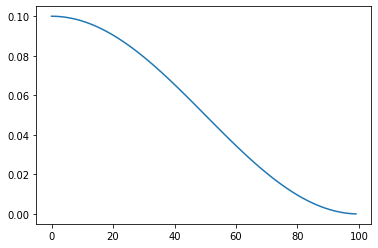

In [92]:
import matplotlib.pyplot as plt
a = np.arange(0, 100)
b = lr_lambda(a)
plt.plot(b)
plt.show()

## training

In [ ]:
acc_func = CategoricalAccuracy()

for epoch in tqdm.tqdm_notebook(range(nb_epoch)):
    start_time = time.time()
    print("")
    
    acc_func.reset()

    m1.train()

    for i, (X, y) in enumerate(training_loader):        
        # Transfer to GPU
        X = X.cuda()
        y = y.cuda()
        
        # predict
        logits = m1(X)

        weak_loss = criterion_bce(logits, y)

        total_loss = weak_loss

        # calc metrics
#         y_pred = torch.log_softmax(logits, dim=1)
        _, y_pred = torch.max(logits, 1)
        acc = acc_func(y_pred, y)

        # ======== back propagation ========
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        # ======== history ========
        print("Epoch {}, {:d}% \t ce: {:.4f} - acc: {:.4f} - took: {:.2f}s".format(
            epoch+1,
            int(100 * (i+1) / nb_batch),
            total_loss.item(),
            acc,
            time.time() - start_time
        ),end="\r")

    # using tensorboard to monitor loss and acc
    tensorboard.add_scalar('train/ce', total_loss.item(), epoch)
    tensorboard.add_scalar("train/acc", 100. * acc, epoch )

    # Validation
    with torch.set_grad_enabled(False):
        # reset metrics
        acc_func.reset()
        m1.eval()

        for X_val, y_val in val_loader:
            # Transfer to GPU
            X_val = X_val.cuda()
            y_val = y_val.cuda()

#             y_weak_val_pred, _ = model(X_val)
            logits = m1(X_val)

            # calc loss
            weak_loss_val = criterion_bce(logits, y_val)

            # metrics
#             y_val_pred =torch.log_softmax(logits, dim=1)
            _, y_val_pred = torch.max(logits, 1)
            acc_val = acc_func(y_val_pred, y_val)

            #Print statistics
            print("Epoch {}, {:d}% \t ce: {:.4f} - acc: {:.4f} - ce val: {:.4f} - acc val: {:.4f} - took: {:.2f}s".format(
                epoch+1,
                int(100 * (i+1) / nb_batch),
                total_loss.item(),
                acc,
                weak_loss_val.item(),
                acc_val,
                time.time() - start_time
            ),end="\r")

        # using tensorboard to monitor loss and acc
        tensorboard.add_scalar('validation/ce', weak_loss_val.item(), epoch)
        tensorboard.add_scalar("validation/acc", 100. * acc_val, epoch )

    for callback in callbacks:
        callback.step()


Epoch 1, 100% 	 ce: 1.9785 - acc: 0.3529 - ce val: 1.8783 - acc val: 0.3335 - took: 11.09s
Epoch 2, 100% 	 ce: 1.6207 - acc: 0.4299 - ce val: 2.0398 - acc val: 0.4138 - took: 10.94s
Epoch 3, 100% 	 ce: 1.5947 - acc: 0.4774 - ce val: 1.6058 - acc val: 0.4971 - took: 10.59s
Epoch 4, 100% 	 ce: 1.5867 - acc: 0.5119 - ce val: 2.2225 - acc val: 0.4987 - took: 10.65s
Epoch 5, 100% 	 ce: 1.5274 - acc: 0.5423 - ce val: 1.5470 - acc val: 0.5252 - took: 10.67s
Epoch 6, 100% 	 ce: 1.0475 - acc: 0.5770 - ce val: 1.2768 - acc val: 0.5493 - took: 10.36s
Epoch 7, 100% 	 ce: 1.1047 - acc: 0.6100 - ce val: 1.8636 - acc val: 0.5420 - took: 10.23s
Epoch 8, 100% 	 ce: 1.1104 - acc: 0.6364 - ce val: 0.7966 - acc val: 0.6141 - took: 10.66s
Epoch 9, 100% 	 ce: 1.2770 - acc: 0.6677 - ce val: 1.3888 - acc val: 0.5342 - took: 10.45s
Epoch 10, 100% 	 ce: 0.9550 - acc: 0.6857 - ce val: 1.0768 - acc val: 0.5864 - took: 10.75s
Epoch 11, 100% 	 ce: 0.9806 - acc: 0.7054 - ce val: 0.9082 - acc val: 0.5962 - took: 10.

# ♫♪.ılılıll|̲̅̅●̲̅̅|̲̅̅=̲̅̅|̲̅̅●̲̅̅|llılılı.♫♪